# Inverted Yield Curves, Recessions, and Equity Market Performance

| Name | EID |
| --- | --- |
| Brandt Green | bwg537 |

### Assumptions/Notes
* Data Sources:
  * [S&P (WRDS)](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/index-sp-500-indexes/portfolios-on-sp-500/)
  * [10-Year Treasury (FRED)](https://fred.stlouisfed.org/series/DGS10)
  * [2-Year Treasury (FRED)](https://fred.stlouisfed.org/series/DGS2)
  * [Recession Dates (FRED)](https://fred.stlouisfed.org/series/JHDUSRGDPBR)
* Data frequency is daily for all variables considered except for the recession dates which is given in quarters.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_theme()
import matplotlib.dates as mdates

from fredapi import Fred
fred = Fred(api_key='37eb22bada238c97f282715480e7d897')

## Data Acquisition & Cleaning

First, select the start and end dates for the analysis. This will affect which data is queried from WRDS and also how the data from FREDS is filtered.

In [29]:
start_date = '1977-12-31'
end_date = '2020-12-31'

The below cell can be used to query S&P data from WRDS so uncomment it out if you need fresh data, but for convenience, I have saved it in a csv file.

In [30]:
# import wrds
# db = wrds.Connection('bgreen41')

# query_string = f"""SELECT * FROM crsp.dsp500 where caldt >= '{start_date}' """
# market_data = db.raw_sql(query_string)
# market_data = market_data[['caldt','vwretd']]
# market_data.columns = ['date','market_return']
# market_data

Grab the data from the appropriate place:

In [31]:
market_data = pd.read_csv('sp500.csv',parse_dates=['date']).set_index('date') # Get S&P 500 Data

# Request below data from WRDS
recessions = pd.DataFrame(fred.get_series('JHDUSRGDPBR'))
ten_year = pd.DataFrame(fred.get_series('DGS10'))
two_year = pd.DataFrame(fred.get_series('DGS2'))

Clean up the data to make sure everything is consistent and easy to interpret:

In [32]:
recessions.columns = ['recession']

# Get Cumulative performance for S&P
market_df = market_data.copy()
market_df['cum_return_market'] = np.cumproduct(market_df['market_return'] + 1)

# Combine the rates into one df
rates_df = ten_year.merge(two_year,left_index=True, right_index=True)
rates_df.columns = ['ten_year','two_year']

In [33]:
combined_data = market_df.merge(rates_df, left_index=True, right_index=True, how='left') # Merge data frames and keep every row where we have market data
combined_data[['ten_year','two_year']] = combined_data[['ten_year','two_year']].interpolate() # Interpolate the yields for any days where the rate data is missing

combined_data['inverted'] = combined_data['two_year'] > combined_data['ten_year']
combined_data.head(3)

,market_return,cum_return_market,ten_year,two_year,inverted
date,,,,,
1978-01-03,-0.013766,0.986234,7.83,7.24,False
1978-01-04,-0.003596,0.982688,7.82,7.24,False
1978-01-05,-0.008235,0.974595,7.83,7.26,False


Now, add another column to indicate if each row was in a recession period or not:

In [34]:
# I feel like the below method is way more complicated than it needs to be
def is_day_recession(date, recession_df:pd.DataFrame) -> bool:
    """Returns true if the date passed in was in a recession."""

    filtered_recession_df = recession_df[(recession_df.index <= date)] # Filter for all periods before the date
    recession_indicator = filtered_recession_df.iloc[-1,0] # Now grab the last date in the df which will be the most recent period and that's the period you are in
    return bool(recession_indicator) # Return boolean value because the indicator is a 1 or 0


combined_data['recession'] = pd.Series(combined_data.index).apply(is_day_recession,recession_df=(recessions)).values

We also need to get the time periods for recessions to add onto our plot later on:

In [35]:
# Easier way to do this?
def get_active_periods(dates, condition_states):
    """General helper function where you need to send in two iterables where the first is a series of dates and the second is a series of boolean values.
    This function will go through and return a list of the starting and ending dates for all time periods where the condition was true.  It sounds vague,
    but it makes sense after you see the output or when you have a specific problem at hand. In this case we use it to figure out what the start and ending
    dates were for recessions.

    The return value will be a list of dictionaries where each dictionary contains two keys: 'start_date' and 'end_date'.
    """
    periods = []
    previous_condition = False

    for period, condition in zip(dates, condition_states):
        if previous_condition == False and condition == True: # This means you are entering an active period
            periods.append({'start_date':period}) # Create a new dict and add start date
            previous_condition = True
        elif previous_condition == True and condition == False: # This means an active period has just ended
            periods[-1]['end_date'] = period
            previous_condition = False
    
    return periods


Getting the periods of recessions and the periods where the yield curve was inverted:

In [36]:
recession_periods = get_active_periods(combined_data.index, combined_data['recession'].values)
inversion_periods = get_active_periods(combined_data.index, combined_data['inverted'].values)

# So we can see what it looks like, print out the first 3 entries of the recession periods
recession_periods[:3]

[{'start_date': Timestamp('1979-04-02 00:00:00'),
  'end_date': Timestamp('1980-07-01 00:00:00')},
 {'start_date': Timestamp('1981-04-01 00:00:00'),
  'end_date': Timestamp('1982-07-01 00:00:00')},
 {'start_date': Timestamp('1989-10-02 00:00:00'),
  'end_date': Timestamp('1991-04-01 00:00:00')}]

Last, we also want to evaluate a strategy where an investor sits out of the market when the yield curve is inverted so we calculate the returns such an investor would have:

In [37]:
def sit_out_inversions(row:pd.Series):
    """Trading rule where we sit out of investments when the yield curve is inverted."""
    if row['two_year'] > row['ten_year']:
        return 0
    else:
        return row['market_return']


strategy_returns = combined_data.apply(sit_out_inversions, axis=1)
cumulative_strategy_returns = np.cumproduct(strategy_returns + 1)

## Plotting:

### 10s vs 2s

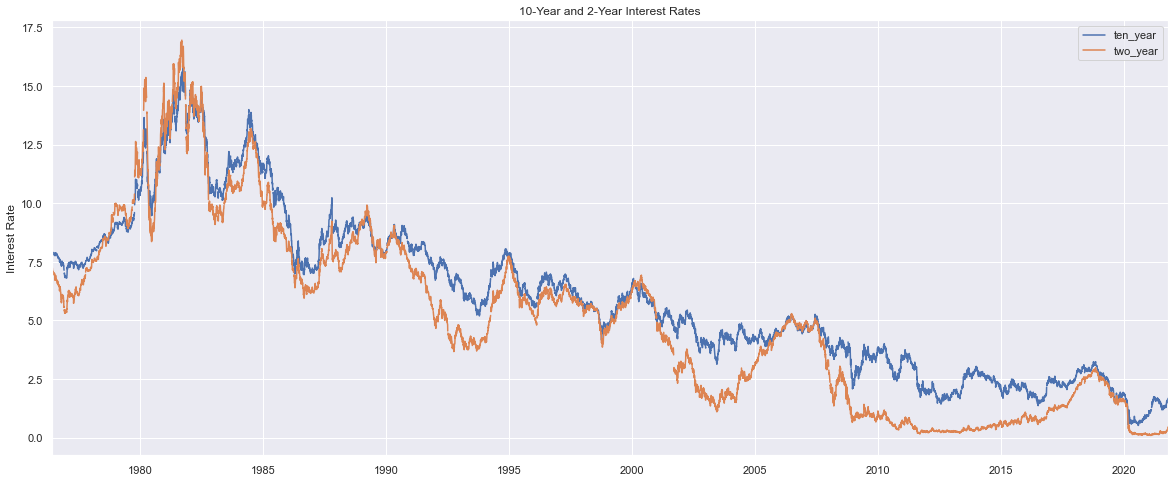

In [38]:
rates_df.plot(figsize=(20,8))
plt.ylabel('Interest Rate')
plt.title('10-Year and 2-Year Interest Rates');

### Inversions, Recessions, and Equity Performance

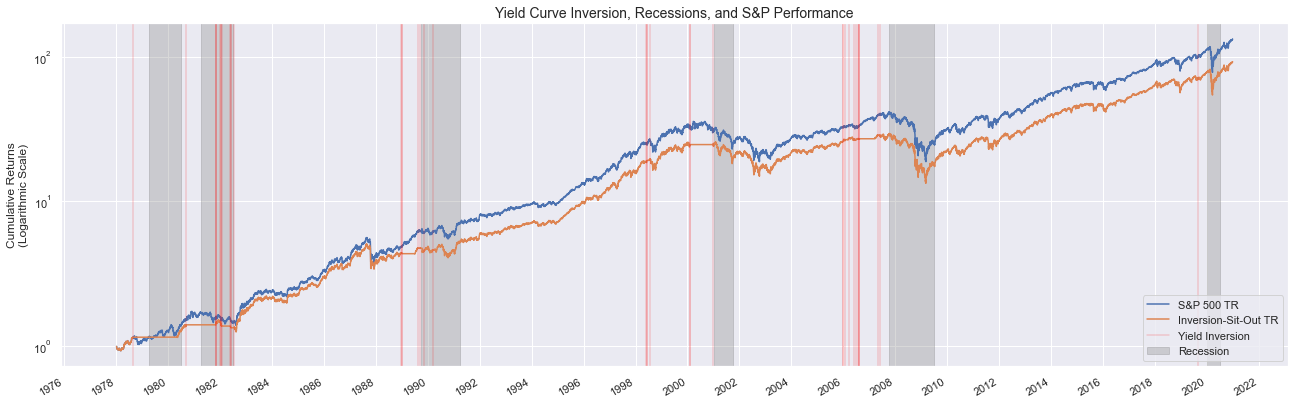

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(22,7)

ax.plot(combined_data.index,combined_data['cum_return_market'].values, label='S&P 500 TR')
ax.plot(cumulative_strategy_returns.index, cumulative_strategy_returns.values, label='Inversion-Sit-Out TR')

# Shade Recessions in Gray
for i, recession_dates in enumerate(recession_periods):
    if i == 0:
        ax.axvspan(xmin=recession_dates['start_date'], xmax=recession_dates['end_date'], alpha=.3, color='grey', label='Recession')
    else:
        ax.axvspan(xmin=recession_dates['start_date'], xmax=recession_dates['end_date'], alpha=.3, color='grey')

# Place Vertical Bar on inversion start dates
for i, inversion_dates in enumerate(inversion_periods):
    if i == 0:
        ax.axvline(inversion_dates['start_date'], alpha=.16, color='red', label='Yield Inversion')
    else:
        ax.axvline(inversion_dates['start_date'], alpha=.16, color='red')


# Uncomment out below if you want to shade the entire period where the yield curve is inverted, not just the start period
# for i, inversion_dates in enumerate(inversion_periods):
#     if i == 0:
#         ax.axvspan(xmin=inversion_dates['start_date'], xmax=inversion_dates['end_date'], alpha=.3, color='red', label='Inverted')
#     else:
#         ax.axvspan(xmin=inversion_dates['start_date'], xmax=inversion_dates['end_date'], alpha=.15, color='red')


# Make date formatting of x-axis look pretty:
ax.set_title('Yield Curve Inversion, Recessions, and S&P Performance',size=14)
ax.set_ylabel('Cumulative Returns\n(Logarithmic Scale)')
ax.set_yscale('log')

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()


ax.legend()
